In [63]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
from inference_attack import *
from model import *
from numpy import argmax
import torch.nn.functional as F

In [64]:
# Configuration
model = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng_seed = 0
dataset_name = "MNIST"                         # "MNIST" or "CIFAR10"
data_path = "./data"

# Part 1 Use pretrained model to create a dataset for gradient classification
pretrained_model_path = "trained_model_MNIST.pth"
criterion_pretrained_model = torch.nn.CrossEntropyLoss()
num_classes = 10
inference_dataset_size = 501
batch_size_pretrained_model = 3

# Part 2 Train gradient classifier on gradient dataset
learning_rate_gradient_classifier = 0.001
criterion_grad_classifier = kl_div
train_size = 0.7
test_size = 1 - train_size
num_epochs = 15
batch_size_gradient_classifier = 16

# Part 3 Make inference on estimated gradient update
target_model_path = "GS_target_2.pth"
learning_rate_pretrained_model = 0.01
num_clients_fl = 10

In [65]:
# Make reproducible
random.seed(rng_seed)
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

## Part 1. Use pretrained model to create a dataset for gradient classification

In [66]:
# load dataset (we use test datasets to train the model on samples that have not been used in training of the global model)
if dataset_name == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)
    input_shape = (1, 28, 28)

elif dataset_name == "CIFAR10":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])
    dataset = datasets.CIFAR10(root=data_path, train=False, download=True, transform=transform)
    input_shape = (3, 32, 32)

else:
    raise ValueError(f"Unsupported dataset: {dataset_name}")

indices = random.sample(range(len(dataset)), inference_dataset_size)
dataset = Subset(dataset, indices=indices)

dataloader = DataLoader(dataset, batch_size=batch_size_pretrained_model, shuffle=False)

In [67]:
# load pretrained model
theta_0 = torch.load(pretrained_model_path)

if model == 1:
    inference_model = Model1(input_shape, num_classes).to(device)
elif model == 2:
    inference_model = Model2(input_shape, num_classes).to(device)
else:
    print('Unknown model:', model)

inference_model.load_state_dict(state_dict=theta_0)

<All keys matched successfully>

In [68]:
# collect gradient features
features = []
labels = []

inference_model.to(device)
inference_model.train() # eval can make some layers behave differently (Not in our case)

for x, y in dataloader:
    x, y = x.to(device), y.to(device)

    # Forward pass
    output = inference_model(x)
    loss = criterion_pretrained_model(output, y)

    # Compute gradients w.r.t. model parameters (except fc)
    fc_params = set(p for p in inference_model.fc.parameters())
    all_params = list(inference_model.parameters())
    params_except_fc = [p for p in all_params if p not in fc_params]
    grad = torch.autograd.grad(loss, params_except_fc, retain_graph=False)
    # grad = torch.autograd.grad(loss, inference_model.parameters(), retain_graph=False)
    grad_vector = torch.cat([g.view(-1) for g in grad])  # Flatten and concatenate

    # Detach and store
    features.append(grad_vector.detach().cpu().float())
    labels.append(multi_hot_encode(y, num_classes))

features = torch.stack(features)
labels = torch.stack(labels).float()

dataset = TensorDataset(features, labels)
input_dim = features.shape[1]
output_dim = labels.shape[1]

## Part 2. Train gradient classifier on gradient dataset

In [69]:
# dataset split
tmp_train = int(train_size*inference_dataset_size/batch_size_pretrained_model)
tmp_test = int(inference_dataset_size/batch_size_pretrained_model-tmp_train)
print(tmp_train, tmp_test)

train_dataset, test_dataset = random_split(dataset, [tmp_train, tmp_test])

train_loader = DataLoader(train_dataset, batch_size=batch_size_gradient_classifier, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_gradient_classifier)

116 51


In [70]:
def prob_to_prediction(inferred, num_preds):
    inferred_copy = inferred.clone()
    predictions = []

    for i in range(num_preds):
        temp_max = torch.argmax(inferred_copy)
        predictions.append(int(temp_max))
        inferred_copy[temp_max] = -inferred_copy[temp_max]
    predictions.sort()
    return predictions

def preds_to_multihot(preds):
    predictions_1hot = [0 for _ in range(10)]

    for i in preds:
        predictions_1hot[i] = 1
    
    return predictions_1hot

def preds_from_multihot(hot_preds):
    predictions = []

    for i in range(len(hot_preds)):
        if hot_preds[i] != 0:
            predictions.append(i) 
    
    return predictions

def compare_multihot(multi_1, multi_2):
    # print(multi_1, multi_2)
    cnt = 0
    for i in range(len(multi_1)):
        if multi_1[i] == multi_2[i]:
            cnt += 1
    return cnt / len(multi_1)

def outputs_to_label(out, size):
    res = []
    for i in out:
        i_pred = prob_to_prediction(i,size)
        # i_pred_multihot = preds_to_multihot(i_pred)
        # res.append(i_pred_multihot)
        res.append(i_pred)
    # res.sort()
    return res

def normalize(batch):
    for j in range(len(batch)):
        den = sum(batch[j])
        for i in range(len(batch[j])):
            batch[j][i] = batch[j][i]/den
    return batch

def evaluate_model_2(model, test_loader, criterion, device='cuda'):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    total_loss = 0.0
    all_preds = []
    all_labels = []
    cosine_sims = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # normalize y_batch
            y_batch = normalize(y_batch)

            outputs = model(x_batch)  # sigmoid output
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * x_batch.size(0)

            preds = outputs.cpu().numpy()
            labels = y_batch.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

            # Compute cosine similarity per sample
            for p, l in zip(preds, labels):
                # Avoid division by zero
                if norm(p) == 0 or norm(l) == 0:
                    cosine_sims.append(0.0)
                else:
                    cos_sim = np.dot(p, l) / (norm(p) * norm(l))
                    cosine_sims.append(cos_sim)
            
            # Accuracy
            outputs_labels = outputs_to_label(outputs, batch_size_pretrained_model)
            y_batch_labels = outputs_to_label(y_batch, batch_size_pretrained_model)
            for i in range(len(y_batch)):
                correct += compare_multihot(y_batch_labels[i],outputs_labels[i])

            total += y_batch.size(0)

    avg_loss = total_loss / len(test_loader.dataset)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    avg_cosine_similarity = np.mean(cosine_sims)
    accuracy = 0
    accuracy = correct / total

    print(f"Test Loss: {avg_loss:.4f} | Cosine Similarity: {avg_cosine_similarity:.4f}, Test Accuracy: {accuracy:.4f}")

    return all_preds, accuracy, avg_loss


def train_grad_classifier_test(model, train_loader, test_loader, criterion, num_epochs=10, lr=1e-3, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history_training_accuracy = []
    history_test_accuracy = []
    history_training_loss = []
    history_test_loss = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)  # raw logits

            # culo softmax on y_batch
            y_batch = normalize(y_batch)

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)

            # Accuracy
            outputs_labels = outputs_to_label(outputs, batch_size_pretrained_model)
            y_batch_labels = outputs_to_label(y_batch, batch_size_pretrained_model)
            for i in range(len(y_batch)):
                correct += compare_multihot(y_batch_labels[i],outputs_labels[i])

            total += y_batch.size(0)

        avg_loss = running_loss / total
        accuracy = 0
        accuracy = correct / total

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

        _, test_accuracy, test_loss = evaluate_model_2(model, test_loader, criterion, device)

        history_training_accuracy.append(accuracy)
        history_test_accuracy.append(test_accuracy)
        history_training_loss.append(avg_loss)
        history_test_loss.append(test_loss)
    
    return history_training_accuracy, history_test_accuracy, history_training_loss, history_test_loss

In [71]:
def pv_to_label(pv_label):
    label = []
    for i in range(len(mh_label)):
        if mh_label[i] == 1:
            pass
        
def mh_norm(mh_label):
    den = sum(mh_label)
    ret = []
    for i in range(len(mh_label)):
        ret.append(mh_label[i] / den)
    return ret

In [72]:
y = [1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
# y_l = mh_to_label(y)
y_norm = mh_norm(y)

print(y_norm)


[0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0]


In [73]:
# Model training
grad_classifier_model = GradientClassifier(input_dim=input_dim, output_dim=output_dim)
grad_classifier_model.to(device)

hist_train_acc, hist_test_acc, hist_train_loss, hist_test_loss = train_grad_classifier_test(grad_classifier_model, train_loader, test_loader, criterion_grad_classifier, num_epochs=num_epochs, lr=learning_rate_gradient_classifier, device=device)

Epoch 1/15 | Loss: 1.3059 | Accuracy: 0.27%
Test Loss: 1.3117 | Cosine Similarity: 0.5378, Test Accuracy: 0.3791
Epoch 2/15 | Loss: 1.2998 | Accuracy: 0.47%
Test Loss: 1.3039 | Cosine Similarity: 0.5745, Test Accuracy: 0.4444
Epoch 3/15 | Loss: 1.2822 | Accuracy: 0.45%
Test Loss: 1.2821 | Cosine Similarity: 0.6478, Test Accuracy: 0.3333
Epoch 4/15 | Loss: 1.2355 | Accuracy: 0.42%
Test Loss: 1.2316 | Cosine Similarity: 0.6707, Test Accuracy: 0.3072
Epoch 5/15 | Loss: 1.1742 | Accuracy: 0.40%
Test Loss: 1.1804 | Cosine Similarity: 0.6588, Test Accuracy: 0.3072
Epoch 6/15 | Loss: 1.1295 | Accuracy: 0.41%
Test Loss: 1.1441 | Cosine Similarity: 0.6654, Test Accuracy: 0.3856
Epoch 7/15 | Loss: 1.1012 | Accuracy: 0.42%
Test Loss: 1.1216 | Cosine Similarity: 0.6684, Test Accuracy: 0.4314
Epoch 8/15 | Loss: 1.0874 | Accuracy: 0.50%
Test Loss: 1.1051 | Cosine Similarity: 0.6838, Test Accuracy: 0.4706
Epoch 9/15 | Loss: 1.0809 | Accuracy: 0.51%
Test Loss: 1.0975 | Cosine Similarity: 0.6864, Test 

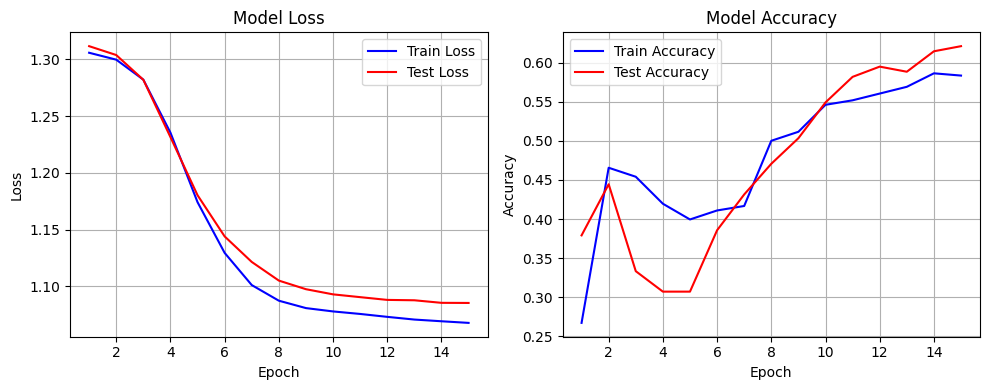

In [74]:
epcs = range(1, num_epochs + 1)

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(epcs, hist_train_acc, 'b-', label='Train Accuracy')
plt.plot(epcs, hist_test_acc, 'r-', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epcs, hist_train_loss, 'b-', label='Train Loss')
plt.plot(epcs, hist_test_loss, 'r-', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [75]:
# Model evaluation
# test_preds, acc, avg_loss = evaluate_model_2(grad_classifier_model, test_loader, criterion_grad_classifier, device)

## Part 3. Make inference on estimated gradient update

In [76]:
# load true gradient update
true_grad = torch.load('DEBUG_true_grads.pth')
# remove fc layer
true_grad = remove_layers(true_grad, ['fc.weight', 'fc.bias'])

In [77]:
# Estimate gradient update
theta_0 = torch.load(pretrained_model_path)
theta_1 = torch.load(target_model_path)
# remove fc layer
theta_0 = remove_layers(theta_0, ['fc.weight', 'fc.bias'])
theta_1 = remove_layers(theta_1, ['fc.weight', 'fc.bias'])
# 
theta_1 = state_dict_scale(theta_1, num_clients_fl)
est_grad = estimate_gradient(theta_0, theta_1, learning_rate_pretrained_model)

cs = state_dicts_average_cosine_similarity(est_grad, true_grad)
mse = state_dicts_mse(est_grad, true_grad)
print(f'cosine similarity between estimated gradient and true gradient: {cs:.4f}')
print(f'mse between estimated gradient and true gradient: {mse:.4f}')

cosine similarity between estimated gradient and true gradient: 1.0000
mse between estimated gradient and true gradient: 0.0000


[0.013757231645286083, 0.0071983374655246735, 0.002373886527493596, 0.006384261883795261, 0.03837749734520912, 0.009539421647787094, 0.00020373534061945975, 0.008918266743421555, 0.6280151605606079, 0.28523215651512146]


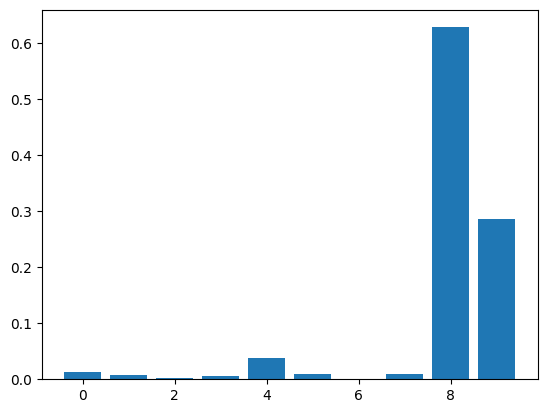

In [78]:
# Inference
est_grad_vector = torch.cat([est_grad[key].view(-1) for key in est_grad.keys()]).unsqueeze(0)
inferred = grad_classifier_model(est_grad_vector)
inferred = inferred.tolist()[0]
print(inferred)

plt.bar(range(num_classes), inferred)
plt.show()

In [79]:
print(inferred)

# from probability to prediction
inferred_copy = inferred.copy()
predictions = []

for i in range(batch_size_pretrained_model):
    temp_max = argmax(inferred_copy)
    predictions.append(int(temp_max))
    inferred_copy[temp_max] = -inferred_copy[temp_max]

print(predictions)

# from prediction to 1_hot
predictions_1hot = [0 for _ in range(10)]

for i in predictions:
    predictions_1hot[i] = 1

print(predictions_1hot)

# from 1_hot to prediction
prediction_2 = []

for i in range(len(predictions_1hot)):
    if predictions_1hot[i] != 0:
        prediction_2.append(i)

print(prediction_2)

[0.013757231645286083, 0.0071983374655246735, 0.002373886527493596, 0.006384261883795261, 0.03837749734520912, 0.009539421647787094, 0.00020373534061945975, 0.008918266743421555, 0.6280151605606079, 0.28523215651512146]
[8, 9, 4]
[0, 0, 0, 0, 1, 0, 0, 0, 1, 1]
[4, 8, 9]
